Here, we'll learn how to:
1. Handle and visualize text and word embeddings
2. Analyze signatures of models' methods in the [Transformers](https://github.com/huggingface/transformers) and [Sentence-Transformers](https://github.com/UKPLab/sentence-transformers) libraries
2. Train custom models using Trainer API
3. Upload metrics to ClearML and draw static and interactive plots.


In [4]:
!pip install clearml datasets tokenizers datasets transformers numpy accelerate seaborn scikit-learn sentence-transformers mplcursors plotly

A sentence transformer model is simply a nn.Sequential module with the following layers:
1. Transformer which for each of input word, returns a contextualized word embedding
2. Pooling layer simply takes the mean of all word embeddings to get a sentence embedding
3. Normalization layer to normalize the sentence embedding to unit length
See: [SentenceTransformer code](https://github.com/UKPLab/sentence-transformers/blob/66e0ee30843dd411c64f37f65447bb38c7bf857a/sentence_transformers/SentenceTransformer.py#L189-L209)

In [5]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

from sentence_transformers import SentenceTransformer

model = SentenceTransformer(model_name)

In [6]:
print(model.modules)

<bound method Module.modules of SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)>


In [7]:
print(model[0].auto_model)
bert_model = model[0].auto_model
print(bert_model.pooler)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


We learn that the model is
[`transformers.models.bert.modeling_bert.BertModel`](https://github.com/huggingface/transformers/blob/45c065109074d60c587d3e562f16531d02a422f6/src/transformers/models/bert/modeling_bert.py#L865)

Let's analyze its
[initialization method](https://github.com/huggingface/transformers/blob/45c065109074d60c587d3e562f16531d02a422f6/src/transformers/models/bert/modeling_bert.py#L878-L888)
to understand its parameters.
```python
def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()
```

[BertEmbeddings](https://github.com/huggingface/transformers/blob/45c065109074d60c587d3e562f16531d02a422f6/src/transformers/models/bert/modeling_bert.py#L180C1-L185C116)
 is a module which is a lookup table that stores embeddings of a fixed dictionary and size.
```python
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        (...)
        
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        past_key_values_length: int = 0,
    ) -> torch.Tensor:

        (...)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings
```

It returns a sum of 3 kinds of embeddings. The most interesting for us are the `word_embeddings` which encode semantic meaning of input words.

Encoder is a module which produces the contextualized word embeddings.

[BertPooler](https://github.com/huggingface/transformers/blob/45c065109074d60c587d3e562f16531d02a422f6/src/transformers/models/bert/modeling_bert.py#L649)
is a very simple `nn.module` which takes the first hidden state and applies a non-linear transformation to it.

```python
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
```

Let's have a look at the return type of the `forward` method of [`transformers.models.bert.modeling_bert.BertModel`](https://github.com/huggingface/transformers/blob/45c065109074d60c587d3e562f16531d02a422f6/src/transformers/models/bert/modeling_bert.py#L865)

```python
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
    
        (...)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            ...
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

```

Looking at [BertEncoder](https://github.com/huggingface/transformers/blob/4ed9ae623d16876ad84ea89dfdf1c9378e36961b/src/transformers/models/bert/modeling_bert.py#L556) and its `forward` method:
```python
class BertEncoder(nn.Module):
    def forward(...):
        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
```

BertEncoder returns `hidden_states` at its 0 index which is passed to BertModel, then to Transformer model and then to SentenceTransformer model. Whew!

In [8]:
text = "I love this movie"
result = model.tokenize([text])
result

{'input_ids': tensor([[ 101, 1045, 2293, 2023, 3185,  102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

Let's ignore `token_type_ids` and `attention_mask` for now. For all our purposes, they will be zeros and ones tensor respectively from now on.
Let's see what `input_ids`, that is ids of tokens, actually mean.

In [9]:
for token in result["input_ids"][0]:
    print(model.tokenizer.decode(token))

[CLS]
i
love
this
movie
[SEP]


`[CLS]` and `[SEP]` tokens are tokens that weren't present in the original text in any way - therefore, they must be special. Let's see what is their meaning in the [BertTokenizer documentation](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer):

> sep_token (`str`, *optional*, defaults to `"[SEP]"`):
>    The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for
>    sequence classification or for a text and a question for question answering. It is also used as the last
>    token of a sequence built with special tokens.
>
> cls_token (`str`, *optional*, defaults to `"[CLS]"`):
>    The classifier token which is used when doing sequence classification (classification of the whole sequence
>    instead of per-token classification). It is the first token of the sequence when built with special tokens.

Special tokens differ model-to-model. `CLS` token is a special token which representation is output by `BertPooler` class as shown above.
The reason for this is simple - we need some kind of information of fixed size output from the model, it's hard to work on sequences of embeddings directly.
Having a special CLS token which representation depends on all other tokens is one way of extracting information from the entire text.
Another way, `sentence-transformers` style, would be to get a mean embedding from all resulting contextualized tokens.

In [10]:
import torch

device = model.device

model.eval() # let's disable any training features like dropout
word_embeddings_module = model[0].auto_model.embeddings.word_embeddings

probe_word = "love"
probe_input_id = model.tokenizer.vocab[probe_word]

probe_word_embedding = word_embeddings_module(torch.tensor(probe_input_id).to(device))

print(probe_word_embedding.shape)

torch.Size([384])


In [11]:
def get_word_embedding(word, model):
    word_embeddings_module = model[0].auto_model.embeddings.word_embeddings
    input_id = model.tokenizer.vocab[word]
    with torch.no_grad():
        embedding = word_embeddings_module(torch.tensor(input_id).to(device)).cpu().numpy()
    return embedding

dog_embedding = get_word_embedding("dog", model)
cat_embedding = get_word_embedding("cat", model)
human_embedding = get_word_embedding("human", model)

from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([dog_embedding], [cat_embedding]))
print(cosine_similarity([dog_embedding], [human_embedding]))
print(cosine_similarity([cat_embedding], [human_embedding]))

[[0.42385635]]
[[0.27439898]]
[[0.13653208]]


Learned word embeddings indicate that animals are closer each other than to humans. This is to be expected, BERT has been trained on Masked Language Modeling, which requires the model to predict what words were under randomly masked places. This causes words that are used in similar context to have similar representations.

In [13]:
def get_sentence_embedding(sentence, model):
    sentence_embedding = model.encode([sentence])[0]
    return sentence_embedding

class_to_sentence_list = {
    "emotion": ["love", "hate", "happy", "sad"],
    "animal": ["dog", "cat", "bird", "fish"],
    "person": ["human", "person", "alien", "cyborg"]
}

rows = [
    {
        "class": class_name,
        "word": word,
        "embedding": get_sentence_embedding(word, model),
    }
    for class_name, word_list in class_to_sentence_list.items()
    for word in word_list
]
import pandas as pd
df = pd.DataFrame(rows)
df

,class,word,embedding
0,emotion,love,"[-0.14027344, 0.029228779, 0.051979534, 0.0118..."
1,emotion,hate,"[-0.059273984, 0.03624199, 0.014119256, 0.0117..."
2,emotion,happy,"[-0.08347837, 0.053237036, -0.0052453866, -0.0..."
3,emotion,sad,"[0.02465379, 0.037095062, 0.01798337, -0.00434..."
4,animal,dog,"[-0.05314703, 0.0141944, 0.007145714, 0.068608..."
5,animal,cat,"[0.03733034, 0.05116179, -0.00030602395, 0.060..."
6,animal,bird,"[0.0030208686, 0.06642966, -0.024045374, 0.030..."
7,animal,fish,"[-0.031851146, 0.060490854, -0.034976307, -0.0..."
8,person,human,"[-0.044023465, 0.009094998, -0.02871744, 0.030..."
9,person,person,"[-0.11306039, 0.026326332, -0.049439445, -0.02..."


Embeddings are dense vectors that have hundreds of dimensions. It is hard to interpret them visually, although there are some ways to visually represent them in 2D such that similar vectors are close to each other. Example methods being: PCA, t-SNE, UMAP.

PCA (Principal Component Analysis) method is quite simple. In short, it finds the best line going through the mean of all points, minimizing the total squared distance to all points. Then, it finds the best perpendicular line, using the same metric.

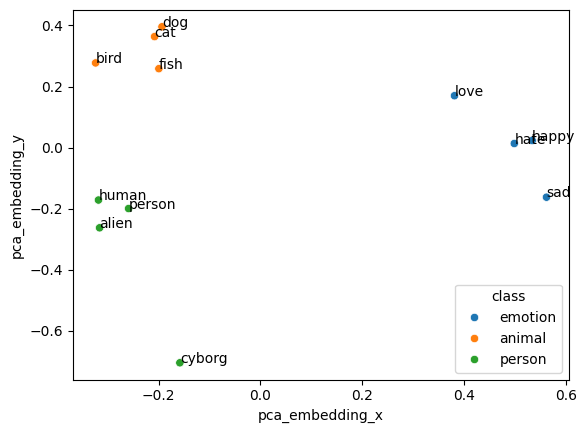

In [14]:
# perform PCA to reduce the dimensionality of the word embeddings
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)

df["pca_embedding"] = list(pca.fit_transform(list(df["embedding"])))
df["pca_embedding_x"] = df["pca_embedding"].apply(lambda x: x[0])
df["pca_embedding_y"] = df["pca_embedding"].apply(lambda x: x[1])

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="pca_embedding_x", y="pca_embedding_y", hue="class")
for i, row in df.iterrows():
    plt.text(row["pca_embedding_x"], row["pca_embedding_y"], row["word"])
plt.show()

As we can see, classes are nicely separable. A linear classifier on the inputs processed by PCA projection would be entirely sufficient.

**Recommended task:**

Try to experiment with different classes of texts! Find a text or a word that could be used in two entirely different contexts. How does its embedding behave?

Now, let's move from words to texts. Transformers process the texts by iteratively making words more contextual. We'll have a shot at classifying whether a Yelp review has been positive or negative, quantified by the number from 0 to 4.

In [19]:
from datasets import load_dataset

dataset_name = "yelp_review_full"

dataset = load_dataset(dataset_name)

dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [20]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

print(df_train["label"].value_counts())
df_train.head()

label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64


,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


We have a nicely balanced dataset, where each review has been rated from 0 to 4. Let's see if we can see some patterns looking at visualized output embeddings.

In [21]:
from tqdm import tqdm
tqdm.pandas()

df_train_part = df_train.sample(1000)
df_train_part["embedding"] = df_train_part["text"].progress_apply(lambda x: get_sentence_embedding(x, model))

# perform PCA to reduce the dimensionality of the word embeddings
pca = PCA(n_components=2)

df_train_part["pca_embedding"] = list(pca.fit_transform(list(df_train_part["embedding"])))
df_train_part["pca_embedding_x"] = df_train_part["pca_embedding"].apply(lambda x: x[0])
df_train_part["pca_embedding_y"] = df_train_part["pca_embedding"].apply(lambda x: x[1])

100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]


<Axes: xlabel='pca_embedding_x', ylabel='pca_embedding_y'>

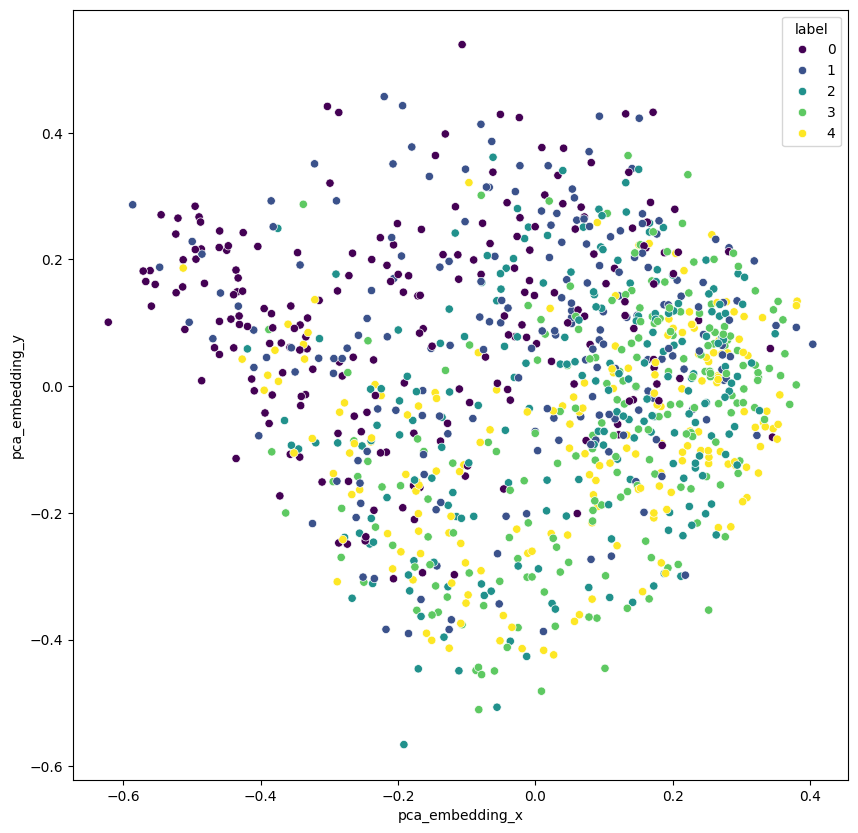

In [22]:
ax, fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_train_part, x="pca_embedding_x", y="pca_embedding_y", hue="label", palette="viridis")

There are some patterns here and there, but the classes aren't really that separable. Remember, this doesn't indicate that embeddings are insufficient for predicting the review sentiment. Embeddings might be close at dimensions which are unimportant to the task itself. Let's try fitting a linear classifier on just the embeddings themselves.

In [23]:
# simple linear classifier

from sklearn.linear_model import LogisticRegression

X_train = np.array(list(df_train_part["embedding"]))
y_train = df_train_part["label"]

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

df_test_part = df_test.sample(1000)

df_test_part["embedding"] = df_test_part["text"].progress_apply(lambda x: get_sentence_embedding(x, model))
X_test = np.array(list(df_test_part["embedding"]))
y_test = df_test_part["label"]

y_pred = clf.predict(X_test)

100%|██████████| 1000/1000 [00:30<00:00, 32.77it/s]


              precision    recall  f1-score   support

           0       0.56      0.64      0.60       208
           1       0.32      0.26      0.29       190
           2       0.31      0.35      0.33       194
           3       0.40      0.40      0.40       205
           4       0.58      0.53      0.56       203

    accuracy                           0.44      1000
   macro avg       0.43      0.44      0.43      1000
weighted avg       0.44      0.44      0.44      1000



<Axes: >

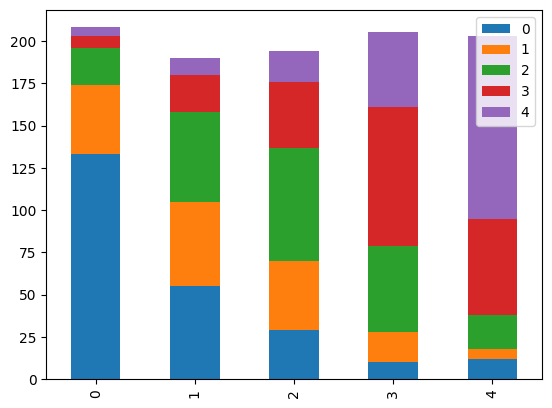

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

df_test_part["y_pred"] = y_pred

coocurence_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        coocurence_matrix[i, j] = ((df_test_part["label"] == i) & (df_test_part["y_pred"] == j)).sum()

# plot stacked bar chart
df_coocurence_matrix = pd.DataFrame(coocurence_matrix, columns=range(5))
df_coocurence_matrix.plot(kind="bar", stacked=True)

This simple classifier has achieved mediocre performance. It might be caused by the fact that our labels are treated completely independently. We could try re-framing our problem as a regression problem.

              precision    recall  f1-score   support

           0       0.60      0.37      0.45       208
           1       0.29      0.34      0.31       190
           2       0.27      0.41      0.33       194
           3       0.32      0.37      0.34       205
           4       0.61      0.34      0.44       203

    accuracy                           0.36      1000
   macro avg       0.42      0.37      0.37      1000
weighted avg       0.42      0.36      0.38      1000



<Axes: >

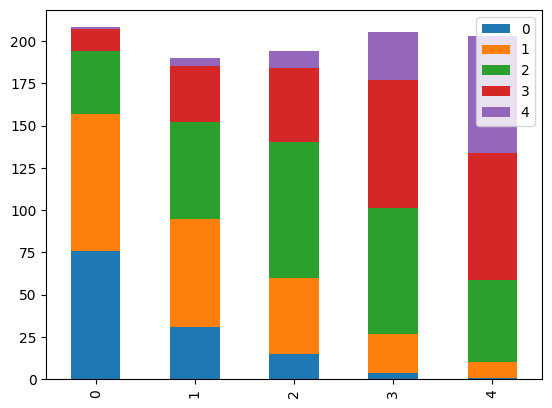

In [25]:
# use linear regression instead of logistic regression
from sklearn.linear_model import LinearRegression

clf = LinearRegression().fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred = np.round(y_pred).astype(int).clip(0, 4)

print(classification_report(y_test, y_pred))

df_test_part["y_pred"] = y_pred

coocurence_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        coocurence_matrix[i, j] = ((df_test_part["label"] == i) & (df_test_part["y_pred"] == j)).sum()

# plot stacked bar chart
df_coocurence_matrix = pd.DataFrame(coocurence_matrix, columns=range(5))

df_coocurence_matrix.plot(kind="bar", stacked=True)

A Linear Regression caused a regression in accuracy. Regression losses usually don't work well on classification problems, as they tend to cling to middle values. Let's try stacking a very small neural network on top of those embeddings - a multi-layer Perceptron.

We'll use Transformers Trainer API to train our small model directly on embeddings. Trainer API has a lot of useful defaults and good to develop quick proof-of-concepts.

For purposes of Training API, the forward method needs to service 2 kinds of scenarios: with labels included and without.

I dearly recommend using ClearML, to have your metrics uploaded automatically. See: [Clearml Notebook](https://colab.research.google.com/drive/1-C_4UVQfUIgM9HOk7aituQJ0VEJDm6OS?usp=sharing)

In [ ]:
#@title Insert your own Credentials

from clearml import Task
from ..Secrets import read_secrets

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'

with open('/home/nojak/Documents/.clearml_ak', 'r') as file:
    ak = file.read()

with open('/home/nojak/Documents/.clearml_sk', 'r') as file:
    sk = file.read()

access_key = ak 
secret_key = sk 

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

task = Task.init(project_name="sentence-transformers", task_name="yelp_review")

ImportError: attempted relative import with no known parent package

: 

In [43]:
# multi layer perceptron

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, criterion=torch.nn.CrossEntropyLoss()):
        super(MLP, self).__init__()
        self.criterion = criterion
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, input_embedding, labels=None):
        logits = self.seq(input_embedding)
        loss = self.criterion(logits, labels) if labels is not None else None
        return {
            "logits": logits,
            "loss": loss
        }


input_dim = 384
hidden_dim = 4 * input_dim
output_dim = 5

mlp_model = MLP(input_dim, hidden_dim, output_dim).to(device)

In [44]:
from datasets import Dataset, DatasetDict

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(df_train_part[["embedding", "label"]]),
    "test": Dataset.from_pandas(df_test_part[["embedding", "label"]])
})
def preprocess(row):
    row["input_embedding"] = torch.tensor(row["embedding"])
    return row

preprocessed_dataset_dict = dataset_dict.map(preprocess)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [45]:
from typing import Any, Dict, List, Tuple
from torch._tensor import Tensor
from torch.nn.modules import Module
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer_pt_utils import nested_detach

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": (preds == labels).mean()}

mlp_model.zero_grad()
mlp_model.train()

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    learning_rate=1e-4,
)

trainer = Trainer(
    model=mlp_model,
    args=training_args,
    train_dataset=preprocessed_dataset_dict["train"],
    eval_dataset=preprocessed_dataset_dict["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/home/nojak/Git/ML-stuff/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



2025-03-11 11:20:03,785 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers_2/accelerator_config[AcceleratorConfig])


  0%|          | 0/630 [00:00<?, ?it/s]

{'loss': 1.608, 'grad_norm': 0.38935375213623047, 'learning_rate': 9.841269841269841e-05, 'epoch': 0.16}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.6064285039901733, 'eval_accuracy': 0.21, 'eval_runtime': 0.4833, 'eval_samples_per_second': 2069.245, 'eval_steps_per_second': 130.362, 'epoch': 0.16}
{'loss': 1.6047, 'grad_norm': 0.2492998093366623, 'learning_rate': 9.682539682539682e-05, 'epoch': 0.32}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.602538824081421, 'eval_accuracy': 0.207, 'eval_runtime': 0.4952, 'eval_samples_per_second': 2019.334, 'eval_steps_per_second': 127.218, 'epoch': 0.32}
{'loss': 1.5984, 'grad_norm': 0.4150356948375702, 'learning_rate': 9.523809523809524e-05, 'epoch': 0.48}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5970193147659302, 'eval_accuracy': 0.253, 'eval_runtime': 0.514, 'eval_samples_per_second': 1945.684, 'eval_steps_per_second': 122.578, 'epoch': 0.48}
{'loss': 1.5909, 'grad_norm': 0.18529845774173737, 'learning_rate': 9.365079365079366e-05, 'epoch': 0.63}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5899347066879272, 'eval_accuracy': 0.287, 'eval_runtime': 0.4917, 'eval_samples_per_second': 2033.647, 'eval_steps_per_second': 128.12, 'epoch': 0.63}
{'loss': 1.5882, 'grad_norm': 0.4586298167705536, 'learning_rate': 9.206349206349206e-05, 'epoch': 0.79}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5793596506118774, 'eval_accuracy': 0.306, 'eval_runtime': 0.5668, 'eval_samples_per_second': 1764.204, 'eval_steps_per_second': 111.145, 'epoch': 0.79}
{'loss': 1.5739, 'grad_norm': 0.3779178857803345, 'learning_rate': 9.047619047619048e-05, 'epoch': 0.95}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5659321546554565, 'eval_accuracy': 0.376, 'eval_runtime': 0.604, 'eval_samples_per_second': 1655.66, 'eval_steps_per_second': 104.307, 'epoch': 0.95}
{'loss': 1.5571, 'grad_norm': 0.45910951495170593, 'learning_rate': 8.888888888888889e-05, 'epoch': 1.11}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5507506132125854, 'eval_accuracy': 0.413, 'eval_runtime': 0.7039, 'eval_samples_per_second': 1420.685, 'eval_steps_per_second': 89.503, 'epoch': 1.11}
{'loss': 1.5353, 'grad_norm': 0.4901335835456848, 'learning_rate': 8.730158730158731e-05, 'epoch': 1.27}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5333417654037476, 'eval_accuracy': 0.371, 'eval_runtime': 0.5598, 'eval_samples_per_second': 1786.486, 'eval_steps_per_second': 112.549, 'epoch': 1.27}
{'loss': 1.517, 'grad_norm': 0.8192266821861267, 'learning_rate': 8.571428571428571e-05, 'epoch': 1.43}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5147343873977661, 'eval_accuracy': 0.362, 'eval_runtime': 0.5841, 'eval_samples_per_second': 1712.143, 'eval_steps_per_second': 107.865, 'epoch': 1.43}
{'loss': 1.5004, 'grad_norm': 0.48990315198898315, 'learning_rate': 8.412698412698413e-05, 'epoch': 1.59}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.4901211261749268, 'eval_accuracy': 0.367, 'eval_runtime': 0.6212, 'eval_samples_per_second': 1609.812, 'eval_steps_per_second': 101.418, 'epoch': 1.59}
{'loss': 1.4585, 'grad_norm': 0.6681351065635681, 'learning_rate': 8.253968253968255e-05, 'epoch': 1.75}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.4611974954605103, 'eval_accuracy': 0.382, 'eval_runtime': 0.5248, 'eval_samples_per_second': 1905.511, 'eval_steps_per_second': 120.047, 'epoch': 1.75}
{'loss': 1.3801, 'grad_norm': 0.6179856657981873, 'learning_rate': 8.095238095238096e-05, 'epoch': 1.9}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.434358835220337, 'eval_accuracy': 0.358, 'eval_runtime': 0.6062, 'eval_samples_per_second': 1649.708, 'eval_steps_per_second': 103.932, 'epoch': 1.9}
{'loss': 1.4025, 'grad_norm': 0.8583243489265442, 'learning_rate': 7.936507936507937e-05, 'epoch': 2.06}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.404401421546936, 'eval_accuracy': 0.391, 'eval_runtime': 0.5744, 'eval_samples_per_second': 1741.068, 'eval_steps_per_second': 109.687, 'epoch': 2.06}
{'loss': 1.3949, 'grad_norm': 0.6795498728752136, 'learning_rate': 7.777777777777778e-05, 'epoch': 2.22}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3906711339950562, 'eval_accuracy': 0.377, 'eval_runtime': 0.5633, 'eval_samples_per_second': 1775.378, 'eval_steps_per_second': 111.849, 'epoch': 2.22}
{'loss': 1.3269, 'grad_norm': 0.5991230607032776, 'learning_rate': 7.619047619047618e-05, 'epoch': 2.38}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.37418794631958, 'eval_accuracy': 0.384, 'eval_runtime': 0.5378, 'eval_samples_per_second': 1859.438, 'eval_steps_per_second': 117.145, 'epoch': 2.38}
{'loss': 1.3376, 'grad_norm': 0.7616568803787231, 'learning_rate': 7.460317460317461e-05, 'epoch': 2.54}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3611454963684082, 'eval_accuracy': 0.383, 'eval_runtime': 0.5435, 'eval_samples_per_second': 1839.801, 'eval_steps_per_second': 115.907, 'epoch': 2.54}
{'loss': 1.2693, 'grad_norm': 1.1711348295211792, 'learning_rate': 7.301587301587302e-05, 'epoch': 2.7}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3457720279693604, 'eval_accuracy': 0.4, 'eval_runtime': 0.5861, 'eval_samples_per_second': 1706.072, 'eval_steps_per_second': 107.483, 'epoch': 2.7}
{'loss': 1.3071, 'grad_norm': 0.8693845868110657, 'learning_rate': 7.142857142857143e-05, 'epoch': 2.86}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3332675695419312, 'eval_accuracy': 0.418, 'eval_runtime': 0.5991, 'eval_samples_per_second': 1669.154, 'eval_steps_per_second': 105.157, 'epoch': 2.86}
{'loss': 1.2612, 'grad_norm': 0.6342710852622986, 'learning_rate': 6.984126984126984e-05, 'epoch': 3.02}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3263568878173828, 'eval_accuracy': 0.422, 'eval_runtime': 0.5454, 'eval_samples_per_second': 1833.559, 'eval_steps_per_second': 115.514, 'epoch': 3.02}
{'loss': 1.2456, 'grad_norm': 0.8517440557479858, 'learning_rate': 6.825396825396825e-05, 'epoch': 3.17}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3205698728561401, 'eval_accuracy': 0.415, 'eval_runtime': 0.5351, 'eval_samples_per_second': 1868.799, 'eval_steps_per_second': 117.734, 'epoch': 3.17}
{'loss': 1.2263, 'grad_norm': 0.5905570983886719, 'learning_rate': 6.666666666666667e-05, 'epoch': 3.33}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.315053939819336, 'eval_accuracy': 0.432, 'eval_runtime': 0.5558, 'eval_samples_per_second': 1799.285, 'eval_steps_per_second': 113.355, 'epoch': 3.33}
{'loss': 1.2725, 'grad_norm': 0.6502236723899841, 'learning_rate': 6.507936507936509e-05, 'epoch': 3.49}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3095319271087646, 'eval_accuracy': 0.429, 'eval_runtime': 0.5903, 'eval_samples_per_second': 1694.142, 'eval_steps_per_second': 106.731, 'epoch': 3.49}
{'loss': 1.2711, 'grad_norm': 1.0278877019882202, 'learning_rate': 6.349206349206349e-05, 'epoch': 3.65}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.306405782699585, 'eval_accuracy': 0.41, 'eval_runtime': 0.5999, 'eval_samples_per_second': 1666.851, 'eval_steps_per_second': 105.012, 'epoch': 3.65}
{'loss': 1.236, 'grad_norm': 1.4116191864013672, 'learning_rate': 6.19047619047619e-05, 'epoch': 3.81}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3023287057876587, 'eval_accuracy': 0.419, 'eval_runtime': 0.6012, 'eval_samples_per_second': 1663.232, 'eval_steps_per_second': 104.784, 'epoch': 3.81}
{'loss': 1.1609, 'grad_norm': 0.6126876473426819, 'learning_rate': 6.0317460317460316e-05, 'epoch': 3.97}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2930265665054321, 'eval_accuracy': 0.441, 'eval_runtime': 0.5495, 'eval_samples_per_second': 1819.764, 'eval_steps_per_second': 114.645, 'epoch': 3.97}
{'loss': 1.2099, 'grad_norm': 0.7170811891555786, 'learning_rate': 5.873015873015873e-05, 'epoch': 4.13}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2919318675994873, 'eval_accuracy': 0.437, 'eval_runtime': 0.5285, 'eval_samples_per_second': 1892.27, 'eval_steps_per_second': 119.213, 'epoch': 4.13}
{'loss': 1.2017, 'grad_norm': 1.5832875967025757, 'learning_rate': 5.714285714285714e-05, 'epoch': 4.29}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2872929573059082, 'eval_accuracy': 0.436, 'eval_runtime': 0.5299, 'eval_samples_per_second': 1887.264, 'eval_steps_per_second': 118.898, 'epoch': 4.29}
{'loss': 1.2264, 'grad_norm': 1.0673061609268188, 'learning_rate': 5.555555555555556e-05, 'epoch': 4.44}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.28804349899292, 'eval_accuracy': 0.427, 'eval_runtime': 0.5934, 'eval_samples_per_second': 1685.134, 'eval_steps_per_second': 106.163, 'epoch': 4.44}
{'loss': 1.2218, 'grad_norm': 1.5612566471099854, 'learning_rate': 5.396825396825397e-05, 'epoch': 4.6}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2910828590393066, 'eval_accuracy': 0.435, 'eval_runtime': 0.6076, 'eval_samples_per_second': 1645.783, 'eval_steps_per_second': 103.684, 'epoch': 4.6}
{'loss': 1.1052, 'grad_norm': 1.0085203647613525, 'learning_rate': 5.2380952380952384e-05, 'epoch': 4.76}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.281855583190918, 'eval_accuracy': 0.437, 'eval_runtime': 0.5395, 'eval_samples_per_second': 1853.431, 'eval_steps_per_second': 116.766, 'epoch': 4.76}
{'loss': 1.1275, 'grad_norm': 0.5055317282676697, 'learning_rate': 5.0793650793650794e-05, 'epoch': 4.92}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.278011441230774, 'eval_accuracy': 0.424, 'eval_runtime': 0.6107, 'eval_samples_per_second': 1637.354, 'eval_steps_per_second': 103.153, 'epoch': 4.92}
{'loss': 1.1517, 'grad_norm': 1.4110803604125977, 'learning_rate': 4.9206349206349204e-05, 'epoch': 5.08}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2751572132110596, 'eval_accuracy': 0.436, 'eval_runtime': 0.5973, 'eval_samples_per_second': 1674.178, 'eval_steps_per_second': 105.473, 'epoch': 5.08}
{'loss': 1.1198, 'grad_norm': 1.8834179639816284, 'learning_rate': 4.761904761904762e-05, 'epoch': 5.24}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2734018564224243, 'eval_accuracy': 0.432, 'eval_runtime': 0.5513, 'eval_samples_per_second': 1813.79, 'eval_steps_per_second': 114.269, 'epoch': 5.24}
{'loss': 1.1214, 'grad_norm': 0.8619702458381653, 'learning_rate': 4.603174603174603e-05, 'epoch': 5.4}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2757946252822876, 'eval_accuracy': 0.433, 'eval_runtime': 0.565, 'eval_samples_per_second': 1769.813, 'eval_steps_per_second': 111.498, 'epoch': 5.4}
{'loss': 1.1043, 'grad_norm': 1.7001819610595703, 'learning_rate': 4.4444444444444447e-05, 'epoch': 5.56}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2706669569015503, 'eval_accuracy': 0.44, 'eval_runtime': 0.5903, 'eval_samples_per_second': 1694.087, 'eval_steps_per_second': 106.727, 'epoch': 5.56}
{'loss': 1.1666, 'grad_norm': 1.0584791898727417, 'learning_rate': 4.2857142857142856e-05, 'epoch': 5.71}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2702527046203613, 'eval_accuracy': 0.461, 'eval_runtime': 0.5897, 'eval_samples_per_second': 1695.791, 'eval_steps_per_second': 106.835, 'epoch': 5.71}
{'loss': 1.1484, 'grad_norm': 1.459773302078247, 'learning_rate': 4.126984126984127e-05, 'epoch': 5.87}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2702845335006714, 'eval_accuracy': 0.453, 'eval_runtime': 0.5972, 'eval_samples_per_second': 1674.597, 'eval_steps_per_second': 105.5, 'epoch': 5.87}
{'loss': 1.1109, 'grad_norm': 1.6470255851745605, 'learning_rate': 3.968253968253968e-05, 'epoch': 6.03}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2643170356750488, 'eval_accuracy': 0.446, 'eval_runtime': 0.5606, 'eval_samples_per_second': 1783.803, 'eval_steps_per_second': 112.38, 'epoch': 6.03}
{'loss': 1.1134, 'grad_norm': 1.2098846435546875, 'learning_rate': 3.809523809523809e-05, 'epoch': 6.19}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2647260427474976, 'eval_accuracy': 0.443, 'eval_runtime': 0.5888, 'eval_samples_per_second': 1698.291, 'eval_steps_per_second': 106.992, 'epoch': 6.19}
{'loss': 1.0953, 'grad_norm': 1.50259268283844, 'learning_rate': 3.650793650793651e-05, 'epoch': 6.35}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2643723487854004, 'eval_accuracy': 0.437, 'eval_runtime': 0.744, 'eval_samples_per_second': 1344.146, 'eval_steps_per_second': 84.681, 'epoch': 6.35}
{'loss': 1.0526, 'grad_norm': 0.7525697350502014, 'learning_rate': 3.492063492063492e-05, 'epoch': 6.51}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2674018144607544, 'eval_accuracy': 0.435, 'eval_runtime': 0.595, 'eval_samples_per_second': 1680.581, 'eval_steps_per_second': 105.877, 'epoch': 6.51}
{'loss': 1.1355, 'grad_norm': 1.3373655080795288, 'learning_rate': 3.3333333333333335e-05, 'epoch': 6.67}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2660913467407227, 'eval_accuracy': 0.441, 'eval_runtime': 0.5957, 'eval_samples_per_second': 1678.836, 'eval_steps_per_second': 105.767, 'epoch': 6.67}
{'loss': 1.1377, 'grad_norm': 1.4128810167312622, 'learning_rate': 3.1746031746031745e-05, 'epoch': 6.83}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2591499090194702, 'eval_accuracy': 0.445, 'eval_runtime': 0.6237, 'eval_samples_per_second': 1603.249, 'eval_steps_per_second': 101.005, 'epoch': 6.83}
{'loss': 1.13, 'grad_norm': 1.357036828994751, 'learning_rate': 3.0158730158730158e-05, 'epoch': 6.98}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.256196141242981, 'eval_accuracy': 0.45, 'eval_runtime': 0.5124, 'eval_samples_per_second': 1951.498, 'eval_steps_per_second': 122.944, 'epoch': 6.98}
{'loss': 1.0097, 'grad_norm': 0.9152733087539673, 'learning_rate': 2.857142857142857e-05, 'epoch': 7.14}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2556012868881226, 'eval_accuracy': 0.445, 'eval_runtime': 0.5337, 'eval_samples_per_second': 1873.852, 'eval_steps_per_second': 118.053, 'epoch': 7.14}
{'loss': 1.0946, 'grad_norm': 1.296486496925354, 'learning_rate': 2.6984126984126984e-05, 'epoch': 7.3}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2554774284362793, 'eval_accuracy': 0.435, 'eval_runtime': 0.5519, 'eval_samples_per_second': 1811.902, 'eval_steps_per_second': 114.15, 'epoch': 7.3}
{'loss': 1.0585, 'grad_norm': 1.0137676000595093, 'learning_rate': 2.5396825396825397e-05, 'epoch': 7.46}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2578986883163452, 'eval_accuracy': 0.435, 'eval_runtime': 0.6067, 'eval_samples_per_second': 1648.299, 'eval_steps_per_second': 103.843, 'epoch': 7.46}
{'loss': 1.0999, 'grad_norm': 1.4258707761764526, 'learning_rate': 2.380952380952381e-05, 'epoch': 7.62}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2583129405975342, 'eval_accuracy': 0.436, 'eval_runtime': 0.5557, 'eval_samples_per_second': 1799.478, 'eval_steps_per_second': 113.367, 'epoch': 7.62}
{'loss': 1.0905, 'grad_norm': 1.3312278985977173, 'learning_rate': 2.2222222222222223e-05, 'epoch': 7.78}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.256636381149292, 'eval_accuracy': 0.436, 'eval_runtime': 0.5643, 'eval_samples_per_second': 1772.167, 'eval_steps_per_second': 111.647, 'epoch': 7.78}
{'loss': 1.1112, 'grad_norm': 1.8487640619277954, 'learning_rate': 2.0634920634920636e-05, 'epoch': 7.94}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2547422647476196, 'eval_accuracy': 0.448, 'eval_runtime': 0.5687, 'eval_samples_per_second': 1758.462, 'eval_steps_per_second': 110.783, 'epoch': 7.94}
{'loss': 1.0892, 'grad_norm': 1.1514276266098022, 'learning_rate': 1.9047619047619046e-05, 'epoch': 8.1}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2546290159225464, 'eval_accuracy': 0.454, 'eval_runtime': 0.6378, 'eval_samples_per_second': 1567.884, 'eval_steps_per_second': 98.777, 'epoch': 8.1}
{'loss': 1.0907, 'grad_norm': 1.1200356483459473, 'learning_rate': 1.746031746031746e-05, 'epoch': 8.25}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.255265712738037, 'eval_accuracy': 0.454, 'eval_runtime': 0.6309, 'eval_samples_per_second': 1585.028, 'eval_steps_per_second': 99.857, 'epoch': 8.25}
{'loss': 1.0595, 'grad_norm': 0.9397770166397095, 'learning_rate': 1.5873015873015872e-05, 'epoch': 8.41}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2535393238067627, 'eval_accuracy': 0.457, 'eval_runtime': 0.5163, 'eval_samples_per_second': 1936.954, 'eval_steps_per_second': 122.028, 'epoch': 8.41}
{'loss': 1.0708, 'grad_norm': 1.076027274131775, 'learning_rate': 1.4285714285714285e-05, 'epoch': 8.57}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2529728412628174, 'eval_accuracy': 0.458, 'eval_runtime': 0.594, 'eval_samples_per_second': 1683.525, 'eval_steps_per_second': 106.062, 'epoch': 8.57}
{'loss': 1.0872, 'grad_norm': 1.377759337425232, 'learning_rate': 1.2698412698412699e-05, 'epoch': 8.73}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2533420324325562, 'eval_accuracy': 0.452, 'eval_runtime': 0.5834, 'eval_samples_per_second': 1714.184, 'eval_steps_per_second': 107.994, 'epoch': 8.73}
{'loss': 1.0366, 'grad_norm': 1.1489074230194092, 'learning_rate': 1.1111111111111112e-05, 'epoch': 8.89}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.252639889717102, 'eval_accuracy': 0.45, 'eval_runtime': 0.644, 'eval_samples_per_second': 1552.884, 'eval_steps_per_second': 97.832, 'epoch': 8.89}
{'loss': 1.122, 'grad_norm': 1.2487472295761108, 'learning_rate': 9.523809523809523e-06, 'epoch': 9.05}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2519882917404175, 'eval_accuracy': 0.448, 'eval_runtime': 0.6542, 'eval_samples_per_second': 1528.482, 'eval_steps_per_second': 96.294, 'epoch': 9.05}
{'loss': 1.0656, 'grad_norm': 1.394567608833313, 'learning_rate': 7.936507936507936e-06, 'epoch': 9.21}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2513935565948486, 'eval_accuracy': 0.449, 'eval_runtime': 0.6401, 'eval_samples_per_second': 1562.202, 'eval_steps_per_second': 98.419, 'epoch': 9.21}
{'loss': 1.0393, 'grad_norm': 1.0094441175460815, 'learning_rate': 6.349206349206349e-06, 'epoch': 9.37}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2515718936920166, 'eval_accuracy': 0.453, 'eval_runtime': 0.6142, 'eval_samples_per_second': 1628.081, 'eval_steps_per_second': 102.569, 'epoch': 9.37}
{'loss': 1.0037, 'grad_norm': 1.4082523584365845, 'learning_rate': 4.7619047619047615e-06, 'epoch': 9.52}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.251603364944458, 'eval_accuracy': 0.454, 'eval_runtime': 0.5463, 'eval_samples_per_second': 1830.495, 'eval_steps_per_second': 115.321, 'epoch': 9.52}
{'loss': 1.0296, 'grad_norm': 0.9835387468338013, 'learning_rate': 3.1746031746031746e-06, 'epoch': 9.68}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2515416145324707, 'eval_accuracy': 0.451, 'eval_runtime': 0.607, 'eval_samples_per_second': 1647.46, 'eval_steps_per_second': 103.79, 'epoch': 9.68}
{'loss': 1.12, 'grad_norm': 1.0596387386322021, 'learning_rate': 1.5873015873015873e-06, 'epoch': 9.84}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2515528202056885, 'eval_accuracy': 0.45, 'eval_runtime': 0.5776, 'eval_samples_per_second': 1731.382, 'eval_steps_per_second': 109.077, 'epoch': 9.84}
{'loss': 1.0662, 'grad_norm': 0.9971157312393188, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2515149116516113, 'eval_accuracy': 0.449, 'eval_runtime': 0.6162, 'eval_samples_per_second': 1622.904, 'eval_steps_per_second': 102.243, 'epoch': 10.0}
{'train_runtime': 64.0495, 'train_samples_per_second': 156.129, 'train_steps_per_second': 9.836, 'train_loss': 1.2261748934549, 'epoch': 10.0}


TrainOutput(global_step=630, training_loss=1.2261748934549, metrics={'train_runtime': 64.0495, 'train_samples_per_second': 156.129, 'train_steps_per_second': 9.836, 'total_flos': 0.0, 'train_loss': 1.2261748934549, 'epoch': 10.0})

In [46]:
trainer.evaluate()

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.2515149116516113,
 'eval_accuracy': 0.449,
 'eval_runtime': 0.598,
 'eval_samples_per_second': 1672.124,
 'eval_steps_per_second': 105.344,
 'epoch': 10.0}

  0%|          | 0/63 [00:00<?, ?it/s]

0.449
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       208
           1       0.35      0.31      0.33       190
           2       0.30      0.35      0.32       194
           3       0.41      0.38      0.39       205
           4       0.59      0.54      0.57       203

    accuracy                           0.45      1000
   macro avg       0.45      0.45      0.44      1000
weighted avg       0.45      0.45      0.45      1000



<Axes: >

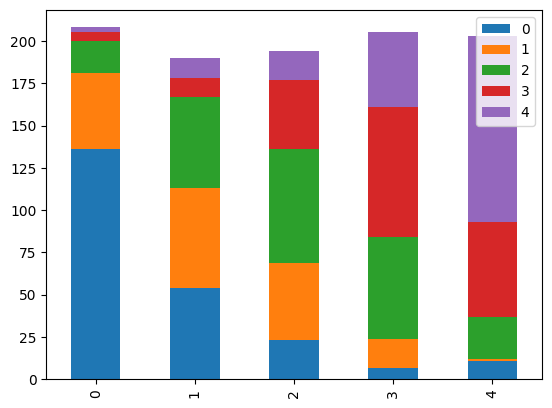

In [47]:
x = trainer.predict(preprocessed_dataset_dict["test"])
Y_label = np.array(preprocessed_dataset_dict["test"]["label"])
Y_pred = x.predictions.argmax(-1)
accuracy = (Y_label == Y_pred).mean()
print(accuracy)

coocurence_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        coocurence_matrix[i, j] = ((Y_label == i) & (Y_pred == j)).sum()

print(classification_report(Y_label, Y_pred))

df_coocurence_matrix = pd.DataFrame(coocurence_matrix, columns=range(5))
df_coocurence_matrix.plot(kind="bar", stacked=True)

It's a small improvement over the linear classifier - it seems that changing base model weights might be required, let's try that!

In [50]:
task.close()

task = Task.init(project_name="sentence-transformers", task_name="yelp_review full model")

In [51]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
base_model = SentenceTransformer(model_name)

def tokenize(row):
    result = base_model.tokenize(row["text"])
    return result

dataset = load_dataset("yelp_review_full")
dataset["train"] = dataset["train"].shuffle().select(range(1000))
dataset["test"] = dataset["test"].shuffle().select(range(1000))

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

The tokenized dataset contains everything that is required by `nn.Sequential` first module - [`Transformer`](https://github.com/UKPLab/sentence-transformers/blob/66e0ee30843dd411c64f37f65447bb38c7bf857a/sentence_transformers/models/Transformer.py#L8) module. The last `Normalize` layer outputs `features` dictionary which contains `sentence_embedding`. See: [code](https://github.com/UKPLab/sentence-transformers/blob/66e0ee30843dd411c64f37f65447bb38c7bf857a/sentence_transformers/models/Normalize.py#L7)

Let's adapt this module, so that at the end we can add a classification head being MLP.

In [52]:
class SentenceTransformerMLP(torch.nn.Module):
    def __init__(self, base_model, input_dim, hidden_dim, output_dim, criterion=torch.nn.CrossEntropyLoss()):
        super(SentenceTransformerMLP, self).__init__()
        self.base_model = base_model
        self.mlp = MLP(input_dim, hidden_dim, output_dim, criterion)

    def forward(self, input_ids, attention_mask, labels=None,):
        d = self.base_model.forward({
            "input_ids": input_ids,
            "attention_mask": attention_mask
        })
        return self.mlp(d["sentence_embedding"], labels)


input_dim = 384
hidden_dim = 4 * input_dim
output_dim = 5

sentence_transformer_mlp_model = SentenceTransformerMLP(base_model, input_dim, hidden_dim, output_dim).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    learning_rate=1e-4,
)

trainer = Trainer(
    model=sentence_transformer_mlp_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/home/nojak/Git/ML-stuff/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

Parameters must be of builtin type (Transformers_3/accelerator_config[AcceleratorConfig])


  0%|          | 0/630 [00:00<?, ?it/s]

{'loss': 1.6118, 'grad_norm': 0.306700199842453, 'learning_rate': 9.841269841269841e-05, 'epoch': 0.16}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.6068063974380493, 'eval_accuracy': 0.23, 'eval_runtime': 37.1183, 'eval_samples_per_second': 26.941, 'eval_steps_per_second': 1.697, 'epoch': 0.16}
{'loss': 1.5987, 'grad_norm': 0.38250210881233215, 'learning_rate': 9.682539682539682e-05, 'epoch': 0.32}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5912981033325195, 'eval_accuracy': 0.311, 'eval_runtime': 36.25, 'eval_samples_per_second': 27.586, 'eval_steps_per_second': 1.738, 'epoch': 0.32}
{'loss': 1.5807, 'grad_norm': 1.3619210720062256, 'learning_rate': 9.523809523809524e-05, 'epoch': 0.48}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.5592505931854248, 'eval_accuracy': 0.354, 'eval_runtime': 36.2721, 'eval_samples_per_second': 27.569, 'eval_steps_per_second': 1.737, 'epoch': 0.48}
{'loss': 1.5305, 'grad_norm': 0.8212367296218872, 'learning_rate': 9.365079365079366e-05, 'epoch': 0.63}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.4971667528152466, 'eval_accuracy': 0.399, 'eval_runtime': 37.0857, 'eval_samples_per_second': 26.965, 'eval_steps_per_second': 1.699, 'epoch': 0.63}
{'loss': 1.4565, 'grad_norm': 3.3285398483276367, 'learning_rate': 9.206349206349206e-05, 'epoch': 0.79}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.4207104444503784, 'eval_accuracy': 0.386, 'eval_runtime': 43.4973, 'eval_samples_per_second': 22.99, 'eval_steps_per_second': 1.448, 'epoch': 0.79}
{'loss': 1.4422, 'grad_norm': 3.0785555839538574, 'learning_rate': 9.047619047619048e-05, 'epoch': 0.95}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3738195896148682, 'eval_accuracy': 0.389, 'eval_runtime': 44.0948, 'eval_samples_per_second': 22.678, 'eval_steps_per_second': 1.429, 'epoch': 0.95}
{'loss': 1.3837, 'grad_norm': 0.9061917662620544, 'learning_rate': 8.888888888888889e-05, 'epoch': 1.11}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.3726842403411865, 'eval_accuracy': 0.376, 'eval_runtime': 41.437, 'eval_samples_per_second': 24.133, 'eval_steps_per_second': 1.52, 'epoch': 1.11}
{'loss': 1.3061, 'grad_norm': 4.090975284576416, 'learning_rate': 8.730158730158731e-05, 'epoch': 1.27}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.320495843887329, 'eval_accuracy': 0.396, 'eval_runtime': 40.3796, 'eval_samples_per_second': 24.765, 'eval_steps_per_second': 1.56, 'epoch': 1.27}
{'loss': 1.2883, 'grad_norm': 1.3241407871246338, 'learning_rate': 8.571428571428571e-05, 'epoch': 1.43}


  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

Let's look at the results.

0.531
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       199
           1       0.47      0.53      0.50       188
           2       0.41      0.45      0.43       180
           3       0.44      0.40      0.42       215
           4       0.66      0.61      0.63       218

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.54      0.53      0.53      1000



<Axes: >

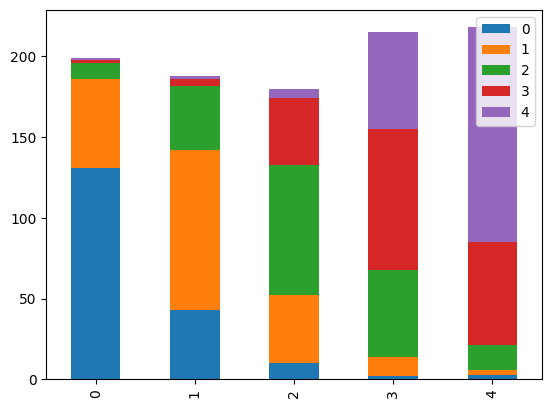

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])
Y_label = np.array(tokenized_dataset["test"]["label"])
Y_pred = predictions.predictions.argmax(-1)
accuracy = (Y_label == Y_pred).mean()
print(accuracy)

coocurence_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        coocurence_matrix[i, j] = ((Y_label == i) & (Y_pred == j)).sum()

print(classification_report(Y_label, Y_pred))

df_coocurence_matrix = pd.DataFrame(coocurence_matrix, columns=range(5))
df_coocurence_matrix.plot(kind="bar", stacked=True)

The predictions have significantly improved, although there is a lot of room for progress. Let's look how the embeddings have changed.

In [ ]:
embeddings = base_model.encode(tokenized_dataset["test"]["text"])

# PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
df_pca = pd.DataFrame(pca_embeddings, columns=["pca_embedding_x", "pca_embedding_y"])
df_pca["label"] = tokenized_dataset["test"]["label"]
df_pca["y_pred"] = Y_pred
df_pca["text"] = tokenized_dataset["test"]["text"]

sns.scatterplot(data=df_pca, x="pca_embedding_x", y="pca_embedding_y", hue="label", palette="viridis")

<Axes: xlabel='pca_embedding_x', ylabel='pca_embedding_y'>

**Recommended task**

We can try to investigate some outliers, maybe some data is wrongly labeled? Or maybe the model clearly doesn't understand something? Try to guess on which heuristics the model has overfit and construct an adversarial dataset.

In [ ]:
import plotly.express as px
# pretty print text
import textwrap

df_pca["text"] = tokenized_dataset["test"]["text"]
df_pca["text"] = df_pca["text"].apply(lambda x: "<br>".join(textwrap.wrap(x, width=80)))

fig = px.scatter(df_pca, x="pca_embedding_x", y="pca_embedding_y", color="label", hover_data=["text"])
fig.show()